Enter region to analyze traffic trends: Downtown


<ipython-input-5-8bd256b06390>:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_region, x=df_region.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="coolwarm")
<ipython-input-5-8bd256b06390>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_region, x=df_region.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="coolwarm")


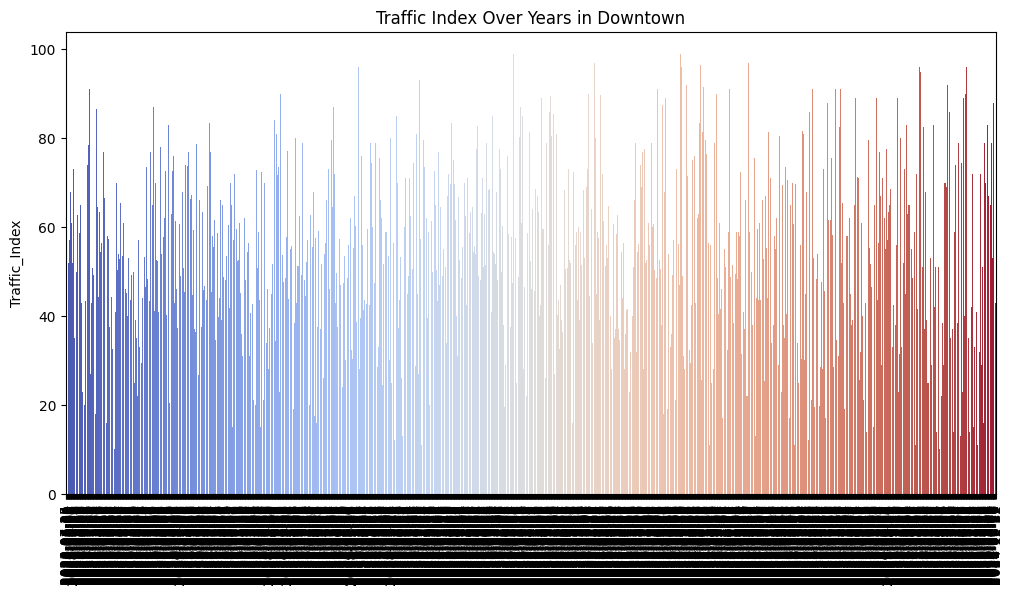

<ipython-input-5-8bd256b06390>:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=high_traffic_df, x=high_traffic_df.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="Reds")


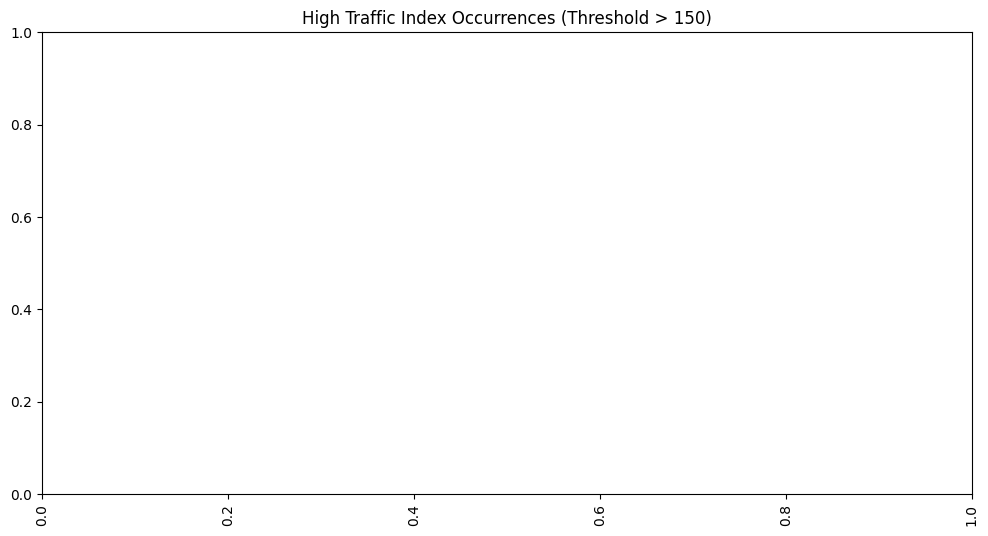

<ipython-input-5-8bd256b06390>:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=high_median_df, x=high_median_df.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="Blues")
<ipython-input-5-8bd256b06390>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=high_median_df, x=high_median_df.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="Blues")


KeyboardInterrupt: 

Exception ignored in: <function _xla_gc_callback at 0x7caa300baa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


Error in callback <function flush_figures at 0x7caabd31bf60> (for post_execute):


KeyboardInterrupt: 

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
file_path = "traffic_data.csv"
df = pd.read_csv(file_path)

# Convert date and time to datetime
# Assuming Date format: MM/DD/YY, Time format: HH:MM:SS
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%m/%d/%y %H:%M:%S')
df.set_index('DateTime', inplace=True)

# User input for region
region_input = input("Enter region to analyze traffic trends: ")
df_region = df[df['Region'] == region_input]

# Check if the region has data
if df_region.empty:
    print(f"No data available for region: {region_input}")
else:
    # Visualize traffic trends for the selected region
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_region, x=df_region.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="coolwarm")
    plt.xticks(rotation=90)
    plt.title(f'Traffic Index Over Years in {region_input}')
    plt.show()

# Analyze high traffic index occurrences
threshold = 150  # Define a threshold for high traffic
high_traffic_df = df[df['Traffic_Index'] > threshold]

plt.figure(figsize=(12, 6))
sns.barplot(data=high_traffic_df, x=high_traffic_df.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="Reds")
plt.xticks(rotation=90)
plt.title(f'High Traffic Index Occurrences (Threshold > {threshold})')
plt.show()

# Calculate median and plot above-median traffic indices
median_traffic = df['Traffic_Index'].median()
high_median_df = df[df['Traffic_Index'] > median_traffic]

plt.figure(figsize=(12, 6))
sns.barplot(data=high_median_df, x=high_median_df.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="Blues")
plt.xticks(rotation=90)
plt.title(f'Traffic Index Above Median ({median_traffic})')
plt.show()

# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['Traffic_Index']])

# Prepare sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 24  # Using past 24 hours to predict the next hour
X, y = create_sequences(df_scaled, SEQ_LENGTH)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Convert back to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"MAE: {mae}, RMSE: {rmse}")

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Traffic Index')
plt.plot(predictions, label='Predicted Traffic Index', linestyle='dashed')
plt.legend()
plt.title('Traffic Flow Prediction')
plt.show()

# Identify regions with highest accident risks
df['Accident_Risk'] = df['Traffic_Index'] + df['Pollution_Index']

plt.figure(figsize=(10, 6))
colors = []
for _, row in df.iterrows():
    if row['Accident_Risk'] > 180:
        colors.append('red')  # High accident risk (High traffic + pollution)
    elif row['Pollution_Index'] > 120:
        colors.append('yellow')  # High pollution
    elif row['Max_Traffic_Time'] in ['Morning', 'Evening']:
        colors.append('blue')  # Peak traffic hours
    else:
        colors.append('green')  # Normal condition

plt.scatter(df.index, df['Traffic_Index'], c=colors, alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Traffic Index')
plt.title('Regions with Highest Accident Risks')
plt.show()


Enter region to analyze traffic trends: Downtown


<ipython-input-3-ec5e1877e450>:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_region_sorted, x=df_region_sorted.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="coolwarm")
<ipython-input-3-ec5e1877e450>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_region_sorted, x=df_region_sorted.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="coolwarm")


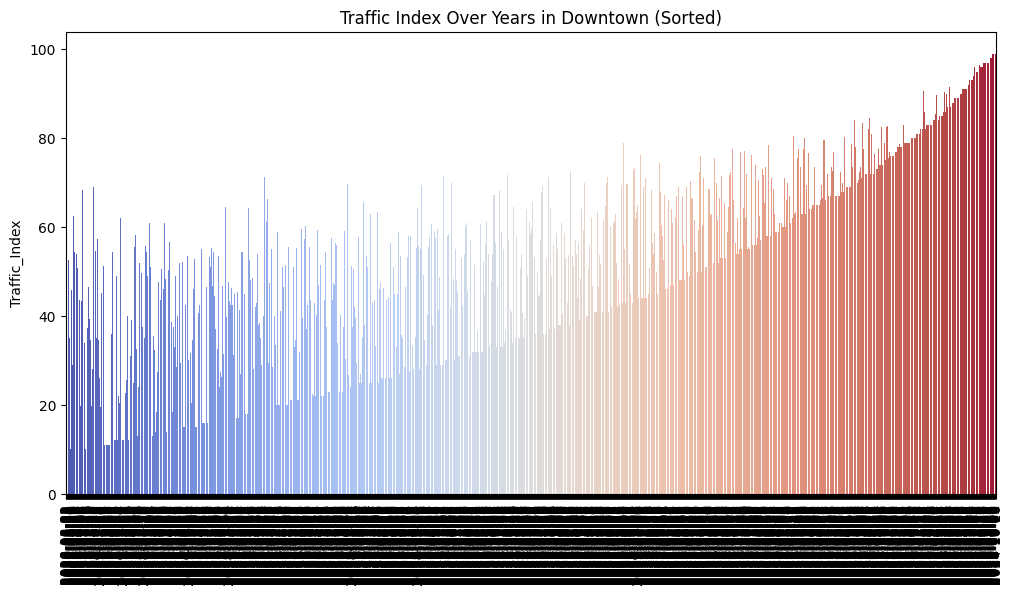

<ipython-input-3-ec5e1877e450>:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_high_traffic, x=df_high_traffic.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="Reds")
<ipython-input-3-ec5e1877e450>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_high_traffic, x=df_high_traffic.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="Reds")


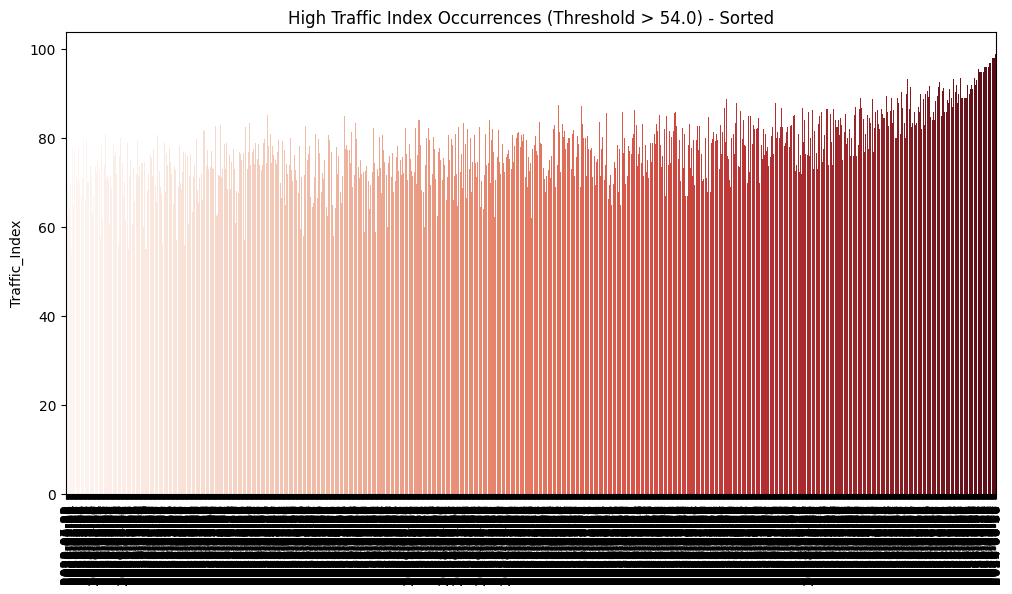

<ipython-input-3-ec5e1877e450>:49: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_high_median, x=df_high_median.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="Blues")
<ipython-input-3-ec5e1877e450>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_high_median, x=df_high_median.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="Blues")


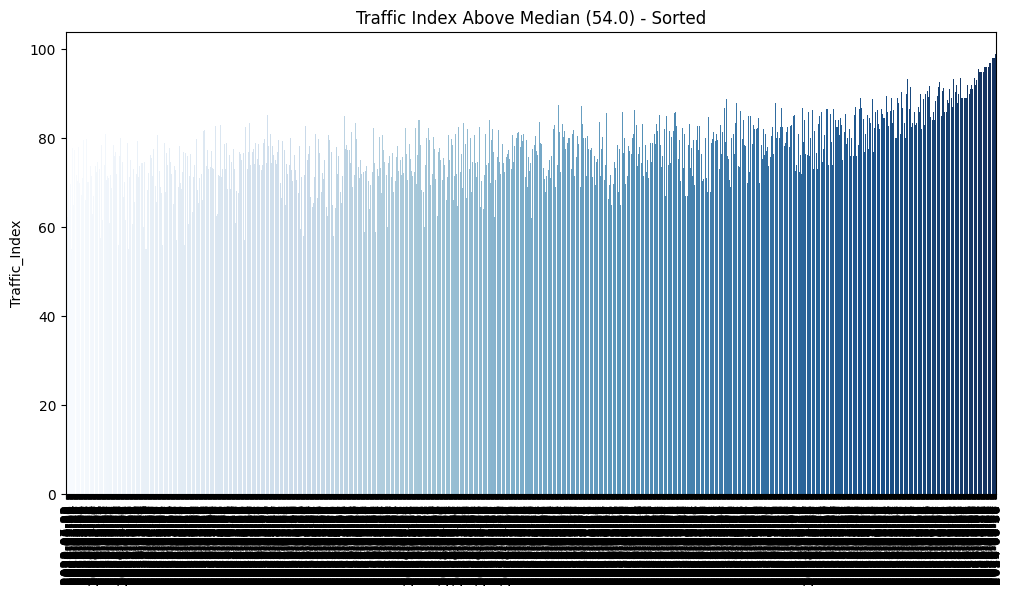

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.0970 - val_loss: 0.0853
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0865 - val_loss: 0.0848
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.0850 - val_loss: 0.0853
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.0854 - val_loss: 0.0850
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0842 - val_loss: 0.0849
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 0.0852 - val_loss: 0.0847
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.0851 - val_loss: 0.0848
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.0838 - val_loss: 0.0847
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.0839 - val_loss: 0.0847
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.0844 - val_loss: 0.0847
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.0837 - val_loss: 0.0850
Epoch 12/20
500/500 ━━━━━━━━━━

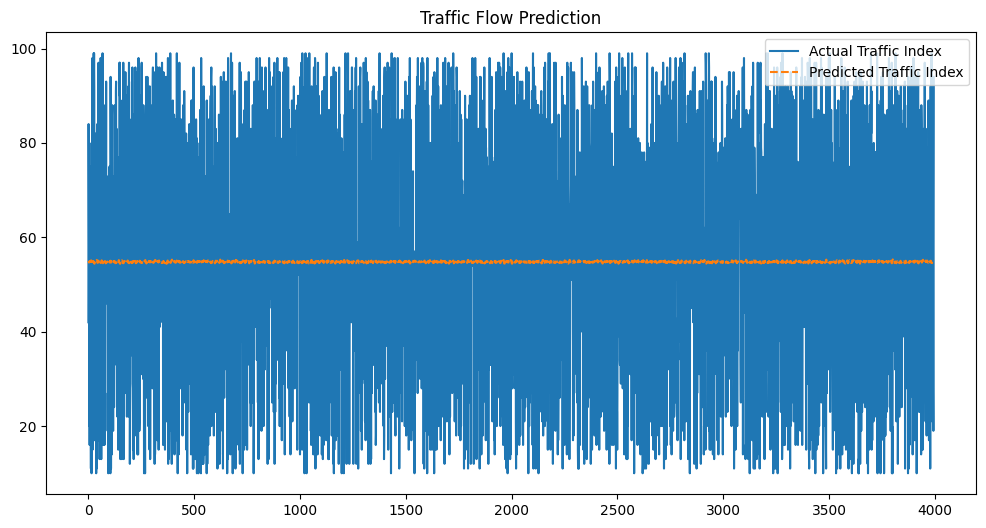

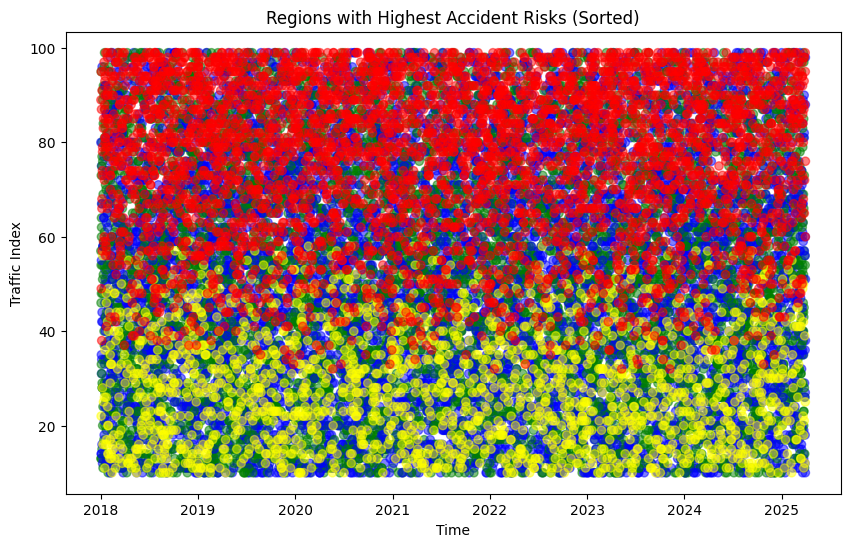

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
file_path = "traffic_data.csv"
df = pd.read_csv(file_path)

# Convert date and time to datetime
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%m/%d/%y %H:%M:%S')
df.set_index('DateTime', inplace=True)

# User input for region
region_input = input("Enter region to analyze traffic trends: ")
df_region = df[df['Region'] == region_input]

if df_region.empty:
    print(f"No data available for region: {region_input}")
else:
    df_region_sorted = df_region.sort_values(by='Traffic_Index')

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_region_sorted, x=df_region_sorted.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="coolwarm")
    plt.xticks(rotation=90)
    plt.title(f'Traffic Index Over Years in {region_input} (Sorted)')
    plt.show()

# High traffic occurrences
threshold = df['Traffic_Index'].median()
df_high_traffic = df[df['Traffic_Index'] > threshold].sort_values(by='Traffic_Index')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_high_traffic, x=df_high_traffic.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="Reds")
plt.xticks(rotation=90)
plt.title(f'High Traffic Index Occurrences (Threshold > {threshold}) - Sorted')
plt.show()

# Median traffic analysis
median_traffic = df['Traffic_Index'].median()
df_high_median = df[df['Traffic_Index'] > median_traffic].sort_values(by='Traffic_Index')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_high_median, x=df_high_median.index.date, y='Traffic_Index', estimator=np.mean, ci=None, palette="Blues")
plt.xticks(rotation=90)
plt.title(f'Traffic Index Above Median ({median_traffic}) - Sorted')
plt.show()

# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['Traffic_Index']])

# Prepare sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 24
X, y = create_sequences(df_scaled, SEQ_LENGTH)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
r2 = r2_score(y_test_actual, predictions)
print(f"MAE: {mae}, RMSE: {rmse}, R2 Score: {r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Traffic Index')
plt.plot(predictions, label='Predicted Traffic Index', linestyle='dashed')
plt.legend()
plt.title('Traffic Flow Prediction')
plt.show()

# Accident risk analysis
df['Accident_Risk'] = df['Traffic_Index'] + df['Pollution_Index']
df_sorted = df.sort_values(by='Accident_Risk')

plt.figure(figsize=(10, 6))
colors = ['red' if row['Accident_Risk'] > 180 else 'yellow' if row['Pollution_Index'] > 120 else 'blue' if row['Max_Traffic_Time'] in ['Morning', 'Evening'] else 'green' for _, row in df_sorted.iterrows()]
plt.scatter(df_sorted.index, df_sorted['Traffic_Index'], c=colors, alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Traffic Index')
plt.title('Regions with Highest Accident Risks (Sorted)')
plt.show()
